#### Wymagane zależności
```sh
pip install liac-arff
pip install graphviz
```
Python 3

In [16]:
import math
import graphviz

### Entropia
<img src="img/h.png" style="height: 60px">


In [17]:
class EntropyMetric(object):
    """Entropy metric H(Bs, D) module (Bs - Bayes net, D - test data set)"""
    def __init__(self, Bs, D):
        # Liczba probek testowych w D
        self.N = len(D)
        # Siec Bs
        self.Bs = Bs
        # Dane testowe
        self.D = D
        
    def check_occurences(self, node_name, parent_name, node_state, parent_state):
        result = 0
        
        for i, p in enumerate(self.D):
            found_node_state = p[node_name]
            
            if (parent_name != ''):
                found_parent_state = p[parent_name]
                is_found = (found_node_state == node_state and found_parent_state == parent_state)

                if (is_found):
                    result += 1
            else:
                if (found_node_state == node_state):
                    result += 1

        return result

    def check_parent_occurences(self, parent_name, parent_state):
        result = 0
        # brak rodzica - przyjmuje się, że wynikiem jest liczba próbek (czyli N)
        if (parent_name == ''):
            return self.N

        for i, p in enumerate(self.D):
            if (p[parent_name] == parent_state):
                result += 1

        return result
    
    def compute_entropy_metric(self):
        result = 0
        
        for i in range(0, len(self.Bs)):
            r_i = self.Bs[i]['r']
            q_i = self.Bs[i]['q']

            for j in range(0, len(q_i)):
                for k in range(0, len(r_i)):
                    N_i_j_k = self.check_occurences(self.Bs[i]['name'], self.Bs[i]['parent'], r_i[k], q_i[j])
                    N_i_j = self.check_parent_occurences(self.Bs[i]['parent'], q_i[j])

                    if (N_i_j_k != 0 and N_i_j != 0):
                        result += (N_i_j_k / self.N) * math.log10(N_i_j_k / N_i_j)
                        
        return -1 * self.N * result

### Metryka AIC 
<img src="img/qaic.png">
<img src="img/k.png">

In [18]:
class AICMetric(object):
    def compute_aic_metric(self, Bs, D):
        return EntropyMetric(Bs, D).compute_entropy_metric() + self.compute_k_factor(Bs)
    
    def compute_k_factor(self, Bs):
        k_factor = 0
        for i, p in enumerate(Bs):
            k_factor += (len(p['r']) - 1) * len(p['q'])
        
        return k_factor

### Metryka MDL (minimum description length)
<img src="img/mdl.png" style="height: 60px"> <br/>
<img src="img/k.png" style="height: 60px">

In [19]:
class MDLMetric(object):
    def compute_mdl_metric(self, Bs, D):
        return EntropyMetric(Bs, D).compute_entropy_metric() + (self.compute_k_factor(Bs) / 2) * math.log10(len(D))
    
    def compute_k_factor(self, Bs):
        k_factor = 0
        for i, p in enumerate(Bs):
            k_factor += (len(p['r']) - 1) * len(p['q'])
        
        return k_factor

------

### Algorytm K2

In [20]:
class K2Algorithm(object):
    def __init__(self, attributes, test_data, scoring_method):
        self.test_data = test_data
        self.scoring_method = scoring_method
        self.attributes = attributes
        
    def find_optimal_net(self):
        Bs = []
        biggest_metric = 0
        
        for i, attribute in enumerate(final_attributes):
            number_of_parents = 0
            # Do sieci dodawany jest pierwszy argument - klasa
            if (i == 0):
                Bs.append({'r': attribute['states'], 'q': ['parent'], 'name': attribute['name'], 'parent': ''})
                continue

            # Poszukujemy polaczenia z najwiekszym wynikiem miary sieci
            biggest_metric_parent_index = -1
            
            for j, parent in enumerate(Bs):
                appended_Bs = Bs.copy()
                appended_Bs.append({'r': attribute['states'], 'q': parent['r'], 'name': attribute['name'], 'parent': parent['name']})
                
                if self.scoring_method == 'aic':
                    metric_value = AICMetric().compute_aic_metric(appended_Bs, sample_data)
                elif self.scoring_method == 'mdl':
                    metric_value = MDLMetric().compute_mdl_metric(appended_Bs, sample_data)
                
                if (metric_value > biggest_metric):
                    biggest_metric_parent_index = j
                    biggest_metric = metric_value
        
            if (biggest_metric_parent_index) != -1:
                Bs.append({'r': attribute['states'], 'q': Bs[biggest_metric_parent_index]['r'], 'name': attribute['name'], 'parent': Bs[biggest_metric_parent_index]['name']})
        
        print(self.scoring_method.upper(), "metric:", biggest_metric)
        
        return Bs

------

### Ładowanie pliku ARFF

In [21]:
import arff
import pprint

pp = pprint.PrettyPrinter(depth=6)

with open('data/weather.arff') as fh:
    data = arff.load(fh)
    
    attributes = []
    for i, p in enumerate(data['attributes']):
        attributes.append({'name': p[0], 'states': p[1]})
    
    sample_data = []
    for i, p in enumerate(data['data']):
        temp_dict = {}
        for j, d in enumerate(p):
            temp_dict.update({attributes[j]['name']: d})
        sample_data.append(temp_dict)
    
    pp.pprint(attributes)

[{'name': 'outlook', 'states': ['sunny', 'overcast', 'rainy']},
 {'name': 'temperature', 'states': ['hot', 'mild', 'cool']},
 {'name': 'humidity', 'states': ['high', 'normal']},
 {'name': 'windy', 'states': ['TRUE', 'FALSE']},
 {'name': 'play', 'states': ['yes', 'no']}]


------

### Wybór argumentu - klasy

In [22]:
    index_of_class_attribute = 4
    print("Class argument: ")
    pp.pprint(attributes[index_of_class_attribute])
    
    final_attributes = []
    final_attributes.append(attributes[index_of_class_attribute])
    
    for i, p in enumerate(attributes):
        if i != index_of_class_attribute:
            final_attributes.append(p)

Class argument: 
{'name': 'play', 'states': ['yes', 'no']}


-----
### Główne wywołanie algorytmu i rysowanie grafu

AIC metric: 40.38298633249521


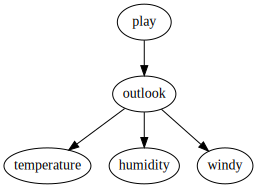

In [23]:
# Metody oceny sieci: 'aic' lub 'mdl'
bayesian_network = K2Algorithm(final_attributes, sample_data, 'aic').find_optimal_net()

graph = graphviz.Digraph()

for i, p in enumerate(bayesian_network):
    if i == 0:
        continue
    graph.edge(p['parent'], p['name'])
graph

In [24]:
probabilities = {}

for argument in bayesian_network:
    for state in argument['r']:
        number_of_states = len(argument['r'])
        number_of_all_samples = len(sample_data)
        number_of_found_states = 0

        for i, p in enumerate(sample_data):
            if (p[argument['name']] == state):
                number_of_found_states += 1

        probabilities.update({state: number_of_found_states})

print(probabilities)

{'yes': 9, 'no': 5, 'sunny': 5, 'overcast': 4, 'rainy': 5, 'hot': 4, 'mild': 6, 'cool': 4, 'high': 7, 'normal': 7, 'TRUE': 6, 'FALSE': 8}
